In [ ]:
pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.4/982.4 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive



image 1/1 /content/img2.jpg: 640x640 2 Potholes, 2016.6ms
Speed: 3.2ms preprocess, 2016.6ms inference, 15.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict2
1 label saved to runs/segment/predict2/labels


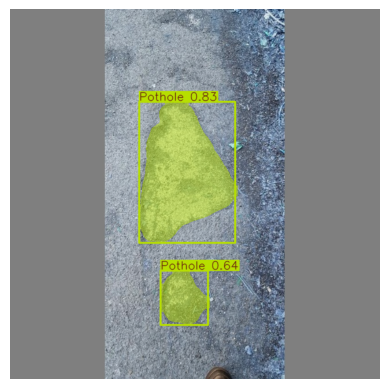

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load your trained YOLOv8m-seg model
model = YOLO("/content/drive/My Drive/yolo_test_results_v8m_segmentation/segment/train/weights/best.pt")  # e.g., "runs/segment/train/weights/best.pt"

# Predict on a single image
results = model("img2.jpg", conf=0.5,iou=0.5, save=True, save_txt=True,save_crop=True)

# Optional: Display the result
for r in results:
    im_array = r.plot()  # returns a numpy array with annotations
    plt.imshow(im_array)
    plt.axis('off')
    plt.show()


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

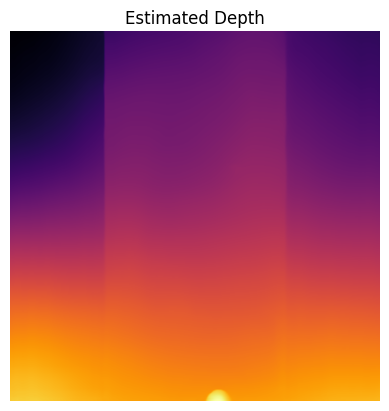

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load MiDaS model
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
midas.eval()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)

# Load MiDaS transforms
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms").dpt_transform

# Load and preprocess image
img_path = "img2.jpg"
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Apply transform and create input tensor
input_tensor = midas_transforms(img_rgb).to(device)

# Ensure it's shape (1, 3, H, W)
if input_tensor.dim() == 3:
    input_tensor = input_tensor.unsqueeze(0)

# Inference
with torch.no_grad():
    prediction = midas(input_tensor)

    # Resize prediction to original image size
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

# Convert to numpy
depth_map = prediction.cpu().numpy()

# Visualize
plt.imshow(depth_map, cmap="inferno")
plt.axis("off")
plt.title("Estimated Depth")
plt.show()



image 1/1 /content/img2.jpg: 640x640 2 Potholes, 1687.8ms
Speed: 2.8ms preprocess, 1687.8ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 640)


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master



Results saved to yolo_midas_results.json


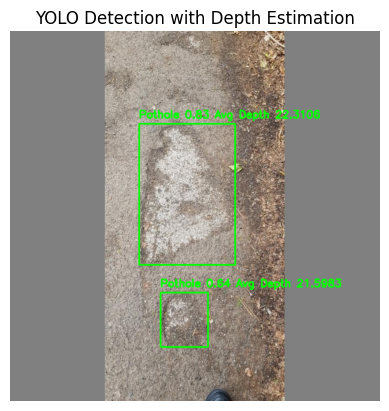

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import json  # for saving the data as a JSON file

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess image
img_path = "img2.jpg"  # Replace this with your image path
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Load your trained YOLOv8m-seg model
model = YOLO("/content/drive/My Drive/yolo_test_results_v8m_segmentation/segment/train/weights/best.pt")  # e.g., "runs/segment/train/weights/best.pt"
model.to(device)

# Predict on a single image
results = model(img_path, conf=0.5,iou=0.5)

# Load MiDaS model
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
midas.eval()
midas.to(device)

# Load MiDaS transforms
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms").dpt_transform

# # Load and preprocess image
# img_path = "img2.jpg"  # Replace this with your image path
# img = cv2.imread(img_path)
# img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Extracting the bounding boxes, labels, and masks
boxes = results[0].boxes.xyxy.cpu().numpy()  # Bounding boxes (x1, y1, x2, y2)
labels = results[0].names  # Class labels
class_indices = results[0].boxes.cls.cpu().numpy()  # Class indices for each detected object
masks = results[0].masks  # Masks (if available)
# print(class_indices)
# Function to get ROI from bounding boxes
def get_roi(image, box):
    x1, y1, x2, y2 = map(int, box)
    return image[y1:y2, x1:x2]

# Process each detected object
object_data = []
for i, box in enumerate(boxes):
    # Get YOLO detection info
    class_index = int(class_indices[i])
    class_name = labels[class_index]
    confidence = float(results[0].boxes.conf[i].cpu().numpy())
    bbox = list(map(int, box))

    # Extract ROI for MiDaS depth estimation
    roi = get_roi(img_rgb, box)

    # Run MiDaS depth estimation
    input_tensor = midas_transforms(roi).to(device)
    with torch.no_grad():
        prediction = midas(input_tensor)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=roi.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    depth_map = prediction.cpu().numpy()
    # Print average depth value inside the ROI
    avg_depth = np.mean(depth_map)
    object_data.append({
        "class": class_name,
        "confidence": round(confidence, 4),
        "bbox": bbox,
        "depth_map": round(float(avg_depth), 4)
    })


    # Draw bounding box and label on the image (YOLO output only)
    cv2.rectangle(img_rgb, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
    cv2.putText(img_rgb, f"{class_name} {confidence:.2f} Avg Depth {avg_depth:.4f}", (bbox[0], bbox[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

json_filename = "yolo_midas_results.json"
with open(json_filename, "w") as f:
    json.dump(object_data, f, indent=4)

print(f"\nResults saved to {json_filename}")


# Visualize the final image with depth map and bounding boxes
plt.imshow(img_rgb)
plt.axis("off")
plt.title("YOLO Detection with Depth Estimation")
plt.show()
